In [54]:
import FalseColor.Color as fc
import numpy as np
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import h5py as h5
import scipy.ndimage as nd
from numba import cuda
import math
import skimage as sk
import cv2
import copy
import time

In [2]:
def ViewImage(Images,title=None,do_hist = False,
              figsize = (6,4), range_min=0,
              range_max=None,cmap='viridis'):
    if do_hist:
        f,ax = plt.subplots(ncols = 2,figsize = figsize)
        ax[0].imshow(Images)
        ax[0].set_title('Image')
        if range_max is None:
            range_max = Images.max()
        ax[1].hist(Images[Images != 0].ravel(),256,[range_min,range_max])
        ax[1].set_title('Histogram')
        if title is not None:
            f.suptitle(title)
    else:
        f,ax = plt.subplots(figsize=figsize)
        ax.imshow(Images,cmap=cmap)
        if title is not None:
            ax.set_title(title)
    return f,ax

In [3]:
#load example data
lung_datapath = 'h5_sample_data/lung'
lung_datafile = os.path.join(lung_datapath,'lung_data.h5')
lung_h5 = h5.File(lung_datafile,'r')

In [4]:
#get individual channels
lung_nuclei = lung_h5['t00000']['s00']['0']['cells'][:].astype(float)
lung_cyto = lung_h5['t00000']['s01']['0']['cells'][:].astype(float)
print(lung_nuclei.shape)

(17, 1024, 1024)


<IPython.core.display.Javascript object>


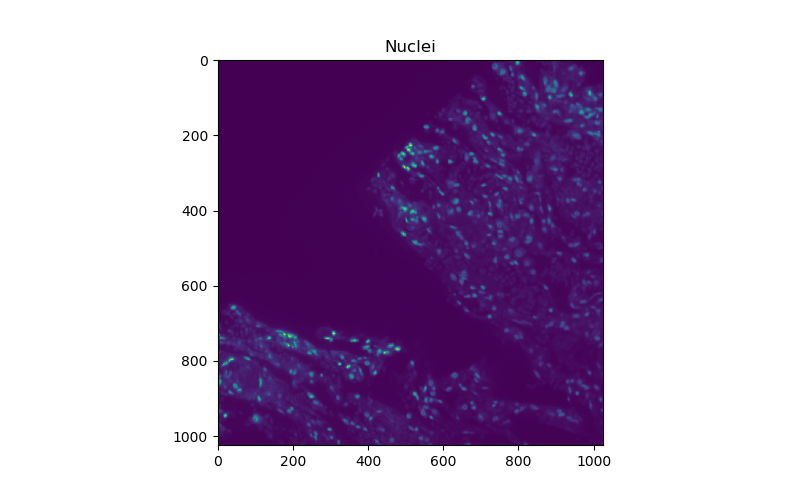

<IPython.core.display.Javascript object>


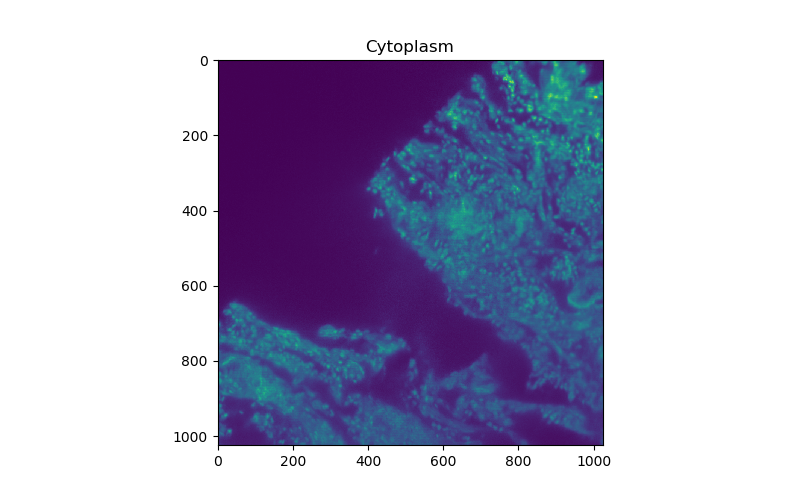

(<Figure size 800x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27976c922b0>)

In [5]:
#View raw data
ViewImage(lung_nuclei[0], title = 'Nuclei', figsize = (8,5))
ViewImage(lung_cyto[0], title = 'Cytoplasm', figsize = (8,5))

In [13]:
#set color levels for false coloring using background subtraction
constants_nuclei = {'R' : 0.344,
                         'G' : 1.000,
                         'B' : 0.050,}

k_nuclei = 0.017
nuclei_RGBsettings = []
for value in constants_nuclei.values():
    nuclei_RGBsettings.append(value*k_nuclei)


constants_cyto = {'R' : 0.0500,
                          'G' : 1.000,
                          'B' : 0.860}
k_cyto = 0.008
cyto_RGBsettings = []
for value in constants_cyto.values():
    cyto_RGBsettings.append(k_cyto*value)

In [15]:
#get flat field images
nuc_flatfield,nuc_bg = fc.getFlatField(np.moveaxis(lung_nuclei,0,1))
cyto_flatfield,cyto_bg = fc.getFlatField(np.moveaxis(lung_cyto,0,1))

<IPython.core.display.Javascript object>


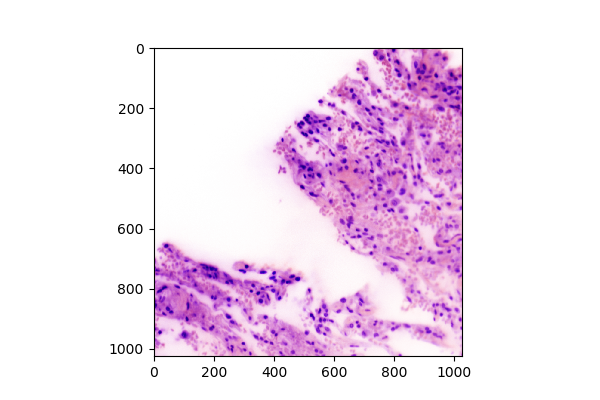

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27921184fd0>)

In [56]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
example_nuclei = copy.deepcopy(lung_nuclei[0]) - nuc_bg
example_nuclei[example_nuclei < 0] = 0
example_cyto = copy.deepcopy(lung_cyto[0]) - cyto_bg
original_settings = fc.rapidFalseColor(example_nuclei,example_cyto,nuclei_RGBsettings,cyto_RGBsettings,
                                       run_normalization=False,nuc_normfactor=10000,cyto_normfactor=5000)
ViewImage(original_settings)

In [16]:
#upsample flat field images
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[:,0,:], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[:,0,:], 16, order = 1, mode = 'nearest')
nuc_flatfield.shape

(1024, 1024)

In [86]:
nuclei_noback = lung_nuclei - nuc_bg
nuclei_noback[nuclei_noback < 0] = 0

cyto_noback = lung_cyto - cyto_bg
cyto_noback[cyto_noback < 0] = 0


In [49]:
sharp_nuclei = np.zeros(nuclei_noback.shape)
sharp_cyto = np.zeros(cyto_noback.shape)

for i in range(len(sharp_nuclei)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_noback[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_noback[i])

In [50]:
#get RGB settings for flat fielding method
settings_dict = fc.getDefaultRGBSettings()

In [89]:
#execute false coloring for whole dataset using flat fielding method
pseudo_colored = []
tstart = time.time()
for i in range(len(lung_nuclei)):
    pseudo_colored.append(fc.rapidFalseColor(sharp_nuclei[i],sharp_cyto[i],nuclei_RGBsettings,cyto_RGBsettings,
                                            run_normalization=True))
print(time.time()-tstart)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mInvalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(int32, 1d, A), tuple(int32 x 2))
 * parameterized
[1mIn definition 0:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 1:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 2:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 3:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 4:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 5:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 6:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 7:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 8:[0m
[1m    All templates rejected with literals.[0m
[1mIn definition 9:[0m
[1m    All templates rejected without literals.[0m
[1mIn definition 10:[0m
[1m    TypeError: cannot index array(int32, 1d, A) with 2 indices: tuple(int32 x 2)[0m
    raised from C:\Users\AERB\Anaconda3\envs\FalseColor\lib\site-packages\numba\typing\arraydecl.py:87
[1mIn definition 11:[0m
[1m    TypeError: cannot index array(int32, 1d, A) with 2 indices: tuple(int32 x 2)[0m
    raised from C:\Users\AERB\Anaconda3\envs\FalseColor\lib\site-packages\numba\typing\arraydecl.py:87
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: typing of intrinsic-call at C:\Users\AERB\Anaconda3\envs\FalseColor\lib\site-packages\FalseColor\Color.py (224)[0m
[1m
File "..\..\..\..\Anaconda3\envs\FalseColor\lib\site-packages\FalseColor\Color.py", line 224:[0m
[1mdef rapidFieldDivision(image,flat_field,output):
    <source elided>
    if row < output.shape[0] and col < output.shape[1]:
[1m        tmp = image[row,col]/flat_field[row,col]
[0m        [1m^[0m[0m


<IPython.core.display.Javascript object>


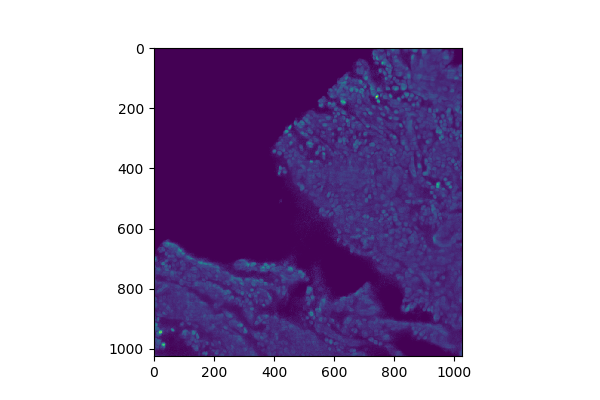

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27922e54278>)

In [92]:
ViewImage(sharp_cyto[0]/cyto_flatfield)

In [98]:
testimg = np.stack((sharp_nuclei[0]/nuc_flatfield,sharp_cyto[0]/cyto_flatfield),axis=-1)
fc.getBackgroundLevels(sharp_nuclei/nuc_flatfield)


IndexError: index 0 is out of bounds for axis 0 with size 0